# Project 1 MTA Turnstile Data

In [3]:
import sys
print("Python Version:", sys.version)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

Python Version: 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]


Our group has chosen the dates August 03, 2019 to September 28, 2019 to reflect the Galas early fall date.

In [140]:
# yymmdd format
dates = ['190803',
        '190810',
        '190817',
        '190824',
        '190831',
        '190907',
        '190914',
        '190921',
        '190928']

# iterate through dates and pull in csv and cat dataframes together
df_turns = []
for date in dates:
    df_turns.append(pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_'+date+'.txt'))

df_turns = pd.concat(df_turns)  

In [141]:
# Clean exits column name.
df_turns.rename(columns={'EXITS                                                               ':'EXITS'}, inplace=True)

In [120]:
# Create a DateTime column that can be used for timeseries
df_turns.loc[:,'DateTime'] = pd.to_datetime(df_turns['DATE'] + ' ' + df_turns['TIME'])

#Converte Date column to proper date type.
df_turns['DATE']  = pd.to_datetime(df_turns['DATE'],format='%m/%d/%Y')

In [153]:
# Order Data Frame
df_turns = df_turns.sort_values(['STATION', 'C/A', 'UNIT', 'SCP','DIVISION','DATE','TIME'])
df_turns.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Entry_Diff
31945,H007,R248,00-00-00,1 AV,L,BMT,07/27/2019,00:00:00,REGULAR,14868945,16617731,NaN
31946,H007,R248,00-00-00,1 AV,L,BMT,07/27/2019,04:00:00,REGULAR,14868945,16617731,0.0
31947,H007,R248,00-00-00,1 AV,L,BMT,07/27/2019,08:00:00,REGULAR,14868945,16617731,0.0
31948,H007,R248,00-00-00,1 AV,L,BMT,07/27/2019,12:00:00,REGULAR,14868945,16617732,0.0
31949,H007,R248,00-00-00,1 AV,L,BMT,07/27/2019,16:00:00,REGULAR,14868945,16617734,0.0


In [158]:
# Caluclate Entries Aggregated at station level by DateTime
df_turns['Entry_Diff']=df_turns.groupby(['STATION', 'C/A', 'UNIT', 'SCP','DIVISION','DATE'],as_index=False)['ENTRIES'].transform(pd.Series.diff)['ENTRIES']

# Caluclate Exits Aggregated at station level by DateTime
df_turns['Exit_Diff']=df_turns.groupby(['STATION', 'C/A', 'UNIT', 'SCP','DIVISION','DATE'],as_index=False)['EXITS'].transform(pd.Series.diff)['EXITS']

#calc time diff
#gs = df.groupby(['STATION','DIVISION','DATE'])["DateTime"]
#df["TIME_DIFF"] = gs.diff().fillna(0) / pd.datetools.timedelta(hours=1)

In [276]:
#Absolute Value to deal with counting backward issues 
df_turns['Entry_Diff'] = abs(df_turns['Entry_Diff'])
df_turns['Exit_Diff']=abs(df_turns['Exit_Diff'])

# Calculate both
df_turns['Total_Traffic']=df_turns['Entry_Diff']+df_turns['Exit_Diff']

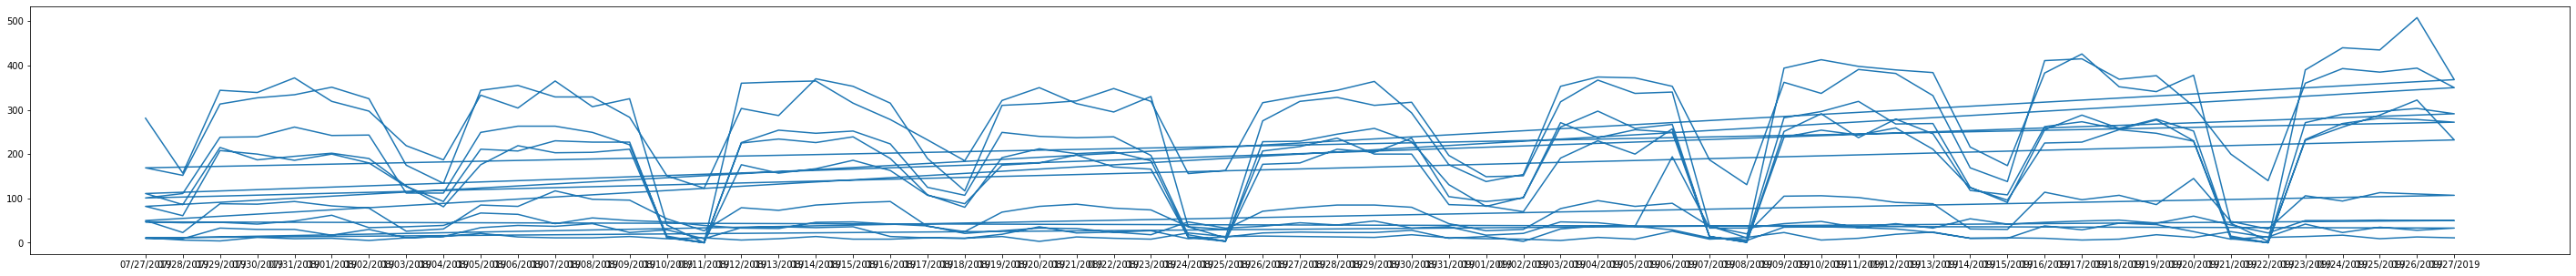

In [277]:
plt.rcParams['figure.figsize'] = [50, 5]

#Calc Time diff#df_turns[df_turns.Total_Traffic<0].head()
chart_dat =df_turns[(df_turns.STATION=='104 ST')].groupby(['STATION', 'C/A', 'UNIT', 'SCP','DIVISION','DATE'],as_index=False).sum()
#chart_dat.head(30)
plt.plot(chart_dat['DATE'],chart_dat['Exit_Diff'])


In [280]:
# Look at daily average traffic for stations
df_per_station = df_no_neg.groupby(['STATION']).mean()
df_per_station.sort_values(by='Total_Traffic',ascending=False).head(10)

,ENTRIES,EXITS,Entry_Diff,Exit_Diff,Total_Traffic
STATION,,,,,
YORK ST,1.451068e+07,1.163534e+07,705.734392,391.160847,1096.895238
MYRTLE AV,1.077271e+07,8.678048e+06,507.281399,269.375199,776.656598
14 ST-UNION SQ,6.858671e+06,4.730815e+06,377.676789,391.216847,768.893636
W 4 ST-WASH SQ,7.789885e+06,7.027113e+06,357.399270,385.637044,743.036314
GRD CNTRL-42 ST,3.277717e+07,5.071199e+07,370.069148,364.812146,734.881294
34 ST-HERALD SQ,8.205943e+07,1.043675e+08,341.592999,353.587185,695.180183
HIGH ST,4.597005e+08,6.163906e+08,297.353100,391.733693,689.086792
21 ST-QNSBRIDGE,1.090703e+07,9.490883e+06,426.484043,251.395897,677.879939
FLUSHING-MAIN,8.159016e+06,7.763259e+06,366.689164,298.621672,665.310836


In [279]:
# add a mask to clear out some weird numbers
mask=(df_turns.Entry_Diff >=0) &\
     (df_turns.Entry_Diff <=6000) &\
     (df_turns.Exit_Diff >=0) & \
     (df_turns.Exit_Diff <=6000) &\
     (df_turns.Total_Traffic) & \
     (df_turns.Total_Traffic <=9000)

df_no_neg = df_turns[mask]
# removed values for future reference
df_rm=df_turns[~mask]

#Aggregate by station and return medians for numeric columns
df_per_station = df_no_neg.groupby(['STATION']).mean()
df_per_station.sort_values(by='Total_Traffic',ascending=False).head(10)

,ENTRIES,EXITS,Entry_Diff,Exit_Diff,Total_Traffic
STATION,,,,,
YORK ST,1.451068e+07,1.163534e+07,705.734392,391.160847,1096.895238
MYRTLE AV,1.077271e+07,8.678048e+06,507.281399,269.375199,776.656598
14 ST-UNION SQ,6.858671e+06,4.730815e+06,377.676789,391.216847,768.893636
W 4 ST-WASH SQ,7.789885e+06,7.027113e+06,357.399270,385.637044,743.036314
GRD CNTRL-42 ST,3.277717e+07,5.071199e+07,370.069148,364.812146,734.881294
34 ST-HERALD SQ,8.205943e+07,1.043675e+08,341.592999,353.587185,695.180183
HIGH ST,4.597005e+08,6.163906e+08,297.353100,391.733693,689.086792
21 ST-QNSBRIDGE,1.090703e+07,9.490883e+06,426.484043,251.395897,677.879939
FLUSHING-MAIN,8.159016e+06,7.763259e+06,366.689164,298.621672,665.310836


In [281]:
# Lets look at most used stations each day (top 10)

#Monday
df_per_station = df_no_neg[df_no_neg.DAY=='Monday'].groupby(['STATION']).mean()
df_per_station.sort_values(by='Total_Traffic',ascending=False).head(10)

AttributeError: 'DataFrame' object has no attribute 'DAY'

In [196]:
#Tuesday
df_per_station = df_no_neg[df_no_neg.DAY=='Tuesday'].groupby(['STATION']).mean()
df_per_station.sort_values(by='Total_Traffic',ascending=False).head(10)

,ENTRIES,EXITS,Entry_Diff,Exit_Diff,Total_Traffic,DAYWEEK
STATION,,,,,,
YORK ST,1.450999e+07,1.163521e+07,808.755556,415.037037,1223.792593,1.0
14 ST-UNION SQ,6.791342e+06,4.669912e+06,436.563443,444.816657,881.380101,1.0
MYRTLE AV,1.078013e+07,8.701817e+06,571.322222,296.255556,867.577778,1.0
GRD CNTRL-42 ST,6.936882e+06,5.386317e+06,443.250089,414.390964,857.641053,1.0
34 ST-HERALD SQ,3.482790e+07,3.067598e+07,402.423227,404.248369,806.671596,1.0
W 4 ST-WASH SQ,7.772268e+06,7.060356e+06,391.897208,414.604061,806.501269,1.0
42 ST-BRYANT PK,9.275206e+07,6.744697e+07,376.997884,411.917460,788.915344,1.0
30 AV,4.205014e+06,5.770450e+06,497.139818,288.449848,785.589666,1.0
CANARSIE-ROCKAW,1.246117e+07,2.853264e+06,371.577778,408.603704,780.181481,1.0


In [198]:
#Wednesday
df_per_station = df_no_neg[df_no_neg.DAY=='Wednesday'].groupby(['STATION']).mean()
df_per_station.sort_values(by='Total_Traffic',ascending=False).head(10)

,ENTRIES,EXITS,Entry_Diff,Exit_Diff,Total_Traffic,DAYWEEK
STATION,,,,,,
YORK ST,1.451443e+07,1.163742e+07,813.540741,408.140741,1221.681481,2.0
GRD CNTRL-42 ST,5.651729e+06,4.214953e+06,480.280136,446.991660,927.271797,2.0
14 ST-UNION SQ,6.839696e+06,4.720447e+06,446.289577,457.540845,903.830423,2.0
MYRTLE AV,1.078316e+07,8.703705e+06,578.138889,291.838889,869.977778,2.0
34 ST-HERALD SQ,3.650412e+07,3.232358e+07,400.839378,412.259067,813.098446,2.0
21 ST-QNSBRIDGE,1.118569e+07,9.736929e+06,516.459459,286.745946,803.205405,2.0
W 4 ST-WASH SQ,7.772964e+06,7.056265e+06,384.108911,412.522277,796.631188,2.0
42 ST-BRYANT PK,9.286195e+07,6.753356e+07,374.574153,416.152542,790.726695,2.0
PAVONIA/NEWPORT,1.086199e+05,1.193456e+05,390.308036,375.529018,765.837054,2.0


In [199]:
#Thursday
df_per_station = df_no_neg[df_no_neg.DAY=='Thursday'].groupby(['STATION']).mean()
df_per_station.sort_values(by='Total_Traffic',ascending=False).head(10)

,ENTRIES,EXITS,Entry_Diff,Exit_Diff,Total_Traffic,DAYWEEK
STATION,,,,,,
YORK ST,1.451885e+07,1.163963e+07,835.170370,425.933333,1261.103704,3.0
GRD CNTRL-42 ST,5.568992e+06,4.103357e+06,467.502083,445.164710,912.666793,3.0
14 ST-UNION SQ,6.804949e+06,4.696303e+06,439.049860,451.542297,890.592157,3.0
MYRTLE AV,1.078619e+07,8.705589e+06,588.205556,290.627778,878.833333,3.0
W 4 ST-WASH SQ,7.918116e+06,7.047022e+06,407.181467,439.622909,846.804376,3.0
34 ST-HERALD SQ,3.549251e+07,3.132829e+07,405.808669,420.141856,825.950525,3.0
42 ST-BRYANT PK,9.284279e+07,6.750779e+07,378.199153,419.385593,797.584746,3.0
21 ST-QNSBRIDGE,1.095550e+07,9.532377e+06,513.502646,283.296296,796.798942,3.0
30 AV,4.222096e+06,5.790862e+06,506.948171,281.176829,788.125000,3.0


In [200]:
#Friday
df_per_station = df_no_neg[df_no_neg.DAY=='Friday'].groupby(['STATION']).mean()
df_per_station.sort_values(by='Total_Traffic',ascending=False).head(10)

,ENTRIES,EXITS,Entry_Diff,Exit_Diff,Total_Traffic,DAYWEEK
STATION,,,,,,
YORK ST,1.452342e+07,1.164186e+07,789.555556,429.066667,1218.622222,4.0
14 ST-UNION SQ,6.857987e+06,4.730787e+06,434.359322,449.575141,883.934463,4.0
MYRTLE AV,1.078920e+07,8.707492e+06,570.388889,281.361111,851.750000,4.0
GRD CNTRL-42 ST,5.672778e+06,4.260521e+06,417.112157,409.630034,826.742190,4.0
W 4 ST-WASH SQ,7.859175e+06,6.997197e+06,386.218477,429.031211,815.249688,4.0
34 ST-HERALD SQ,3.698331e+07,3.277794e+07,392.297191,414.397717,806.694908,4.0
JKSN HT-ROOSVLT,5.574103e+06,5.190185e+06,460.977695,317.748451,778.726146,4.0
21 ST-QNSBRIDGE,1.090718e+07,9.489958e+06,493.448454,271.304124,764.752577,4.0
SUTPHIN-ARCHER,1.270741e+07,6.812790e+06,415.434870,349.254509,764.689379,4.0


In [201]:
#Saturday
df_per_station = df_no_neg[df_no_neg.DAY=='Saturday'].groupby(['STATION']).mean()
df_per_station.sort_values(by='Total_Traffic',ascending=False).head(10)

,ENTRIES,EXITS,Entry_Diff,Exit_Diff,Total_Traffic,DAYWEEK
STATION,,,,,,
YORK ST,1.449966e+07,1.162919e+07,485.229630,337.162963,822.392593,5.0
W 4 ST-WASH SQ,7.702576e+06,6.979584e+06,305.556995,341.638601,647.195596,5.0
MYRTLE AV,1.071766e+07,8.527470e+06,390.471910,223.786517,614.258427,5.0
14 ST-UNION SQ,6.923580e+06,4.777337e+06,273.577231,295.475973,569.053204,5.0
JUNCTION BLVD,6.229109e+06,7.531629e+06,295.229437,239.051948,534.281385,5.0
JKSN HT-ROOSVLT,5.514016e+06,5.127878e+06,311.357374,221.333692,532.691066,5.0
HIGH ST,3.851917e+08,3.591921e+08,213.306667,313.808889,527.115556,5.0
FLUSHING-MAIN,8.210231e+06,7.811758e+06,278.683979,244.594190,523.278169,5.0
HOYT-SCHER,8.590370e+06,8.359265e+06,260.635556,261.440000,522.075556,5.0


In [202]:
#Sunday
df_per_station = df_no_neg[df_no_neg.DAY=='Sunday'].groupby(['STATION']).mean()
df_per_station.sort_values(by='Total_Traffic',ascending=False).head(10)

,ENTRIES,EXITS,Entry_Diff,Exit_Diff,Total_Traffic,DAYWEEK
STATION,,,,,,
YORK ST,1.450258e+07,1.163102e+07,472.059259,335.622222,807.681481,6.0
MYRTLE AV,1.077477e+07,8.698560e+06,327.550000,221.655556,549.205556,6.0
W 4 ST-WASH SQ,7.724032e+06,6.999555e+06,259.315584,275.400000,534.715584,6.0
HIGH ST,3.903514e+08,3.639774e+08,193.842342,288.747748,482.590090,6.0
HOYT-SCHER,8.362490e+06,8.175610e+06,224.736364,234.172727,458.909091,6.0
PROSPECT PARK,8.443268e+06,7.772871e+06,245.799163,195.644351,441.443515,6.0
JKSN HT-ROOSVLT,5.575740e+06,5.196178e+06,249.711183,189.811075,439.522258,6.0
14 ST-UNION SQ,6.903972e+06,4.764798e+06,210.356125,226.298006,436.654131,6.0
GRAND ST,6.823201e+06,6.000454e+06,240.860000,194.790000,435.650000,6.0


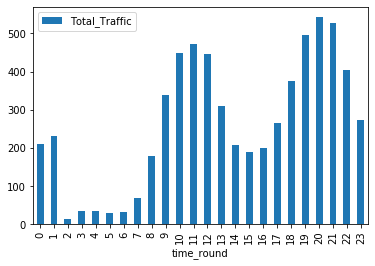

In [226]:
time_mean = df_no_neg.groupby(['TIME'],as_index=False).mean()
time_mean['time_round']=pd.to_datetime(time_mean['TIME'], format='%H:%M:%S')
time_mean['time_round']=time_mean['time_round'].dt.round('H').dt.hour

time_mean=time_mean.groupby(['time_round'],as_index=False).mean()
time_mean.plot.bar(x='time_round',y='Total_Traffic')